In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier  

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df_RF= pd.read_csv("../../Data/processed/urldata-v3-enhanced.csv")  


In [2]:
df = pd.read_csv("../../Data/processed/final.csv") 

In [ ]:
additional_suspicious_words = [
    "webscr", "viewer.php",        
    "getImage.asp",      
    "mail.php",          
    "link=",            
]

# "plugins", "personal", "update", "verification", "blog", ".bin", "order", "files"

def has_additional_suspicious_words(url):
    url_lower = url.lower()
    return int(any(word.lower() in url_lower for word in additional_suspicious_words))

df_RF['has_additional_susp_words'] = df_RF['url'].apply(has_additional_suspicious_words)

print("Stricter column distribution:")
print(df_RF['has_additional_susp_words'].value_counts())

Stricter column distribution:
has_additional_susp_words
0    449376
1       800
Name: count, dtype: int64


In [ ]:
print("Sample URLs with additional suspicious words (refined):")
sample_with_words = df_RF[df_RF['has_additional_susp_words'] == 1]['url'].head(10)
for url in sample_with_words:
    print(url)

Sample URLs with additional suspicious words (refined):
https://www.chicago.gopride.com/news/worldfeed.cfm?golink=5CC3A286EC2463A17244C6BC5797D16BO44550
https://www.content.lib.utah.edu/cdm4/item_viewer.php?CISOROOT=/UU_EAD&CISOPTR=1748
https://www.content.lib.utah.edu/cdm4/item_viewer.php?CISOROOT=/UU_EAD&CISOPTR=2227
https://www.contentdm.acpl.lib.in.us/cdm4/item_viewer.php?CISOROOT=/coll3&CISOPTR=4283&REC=14
https://www.dentoncounty.com/dept/main.asp?Dept=124&Link=896
https://www.email12.secureserver.net/webmail.php?login=1
https://www.ironmaidencommentary.com/?link=tributes&url=index&lang=eng
https://www.reflections.mndigital.org/cdm4/item_viewer.php?CISOROOT=/mgs&CISOPTR=780&CISOBOX=1&REC=10
https://www.admission.com/index.php?tm_link=tm_homeA_logo&language=en&l=EN
https://www.affarilegno.it/it/messages_free.php?id_link=181774&sursa=Italiana&user=&pass=


In [ ]:
def add_tld_features(df):
    df = df.copy()
    
    suspicious_tlds = ['tk', 'ml', 'ga', 'cf', 'cc', 'pw', 'top']
    df['has_suspicious_tld'] = df['tld'].isin(suspicious_tlds).astype(int)
    
    common_tlds = ['com', 'org', 'net', 'edu', 'gov']
    df['has_uncommon_tld'] = (~df['tld'].isin(common_tlds)).astype(int)
    
    return df
df_RF = add_tld_features(df_RF)

In [ ]:
from urllib.parse import urlparse

MULTIPART_TLDS = {
    'co.uk', 'ac.uk', 'gov.uk',
    'com.au', 'net.au', 'org.au',
    'co.in', 'gov.in',
    'co.jp',
}

def count_subdomains(url_or_domain):
    try:
        if url_or_domain.startswith(('http://', 'https://')):
            domain = urlparse(url_or_domain).netloc
        else:
            domain = url_or_domain

        domain = domain.split(':')[0]
        parts = [p for p in domain.split('.') if p]

        if len(parts) <= 2:
            return 0

        tld = ".".join(parts[-2:])
        if tld in MULTIPART_TLDS and len(parts) > 2:
            return len(parts) - 3  
        else:
            return len(parts) - 2  

    except Exception:
        return 0


In [20]:
df_RF['subdomain_count'] = df_RF['url'].apply(count_subdomains)

In [ ]:
def no_www(url):
    try:
        hostname = urlparse(url).netloc
        return 0 if hostname.startswith("www.") else 1
    except:
        return 1   
df_RF['no_www'] = df_RF['url'].apply(no_www)


In [23]:
import tldextract

df_RF['tld'] = df_RF['url'].apply(lambda url: tldextract.extract(url).suffix)

In [24]:
df_RF['tld_length'] = df_RF['tld'].apply(lambda x: len(x) if isinstance(x, str) else -1)


In [ ]:
import re

short_url_pattern = re.compile(
    r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
    r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
    r'short\.to|budurl\.com|ping\.fm|post\.ly|just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
    r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|lnkd\.in|'
    r'db\.tt|qr\.ae|adf\.ly|bitly\.com|cur\.lv|ow\.ly|ity\.im|q\.gs|po\.st|bc\.vc|twitthis\.com|'
    r'u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|prettylinkpro\.com|scrnch\.me|'
    r'filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|link\.zip\.net',
    re.IGNORECASE
)

def shortening_service(url):
    if short_url_pattern.search(url):
        return 1  
    else:
        return 0   

df_RF['short_url'] = df_RF['url'].apply(shortening_service)


In [ ]:
from urllib.parse import urlparse
import re

def consonant_ratio(url):
    if not isinstance(url, str) or url.strip() == '':
        return 0   

    try:
        domain = urlparse(url).netloc.lower()
    except Exception:
        return 0   
    
    if domain.startswith('www.'):
        domain = domain[4:]
    
    vowels = "aeiou"
    letters = re.findall(r'[a-z]', domain)
    
    count_consonant_pairs = 0
    total_pairs = 0
    
    for i in range(len(letters) - 1):
        total_pairs += 1
        if letters[i] not in vowels and letters[i+1] not in vowels:
            count_consonant_pairs += 1
    
    if total_pairs == 0:
        return 0
    
    return count_consonant_pairs / total_pairs

df_RF['consonant_pair_ratio'] = df_RF['url'].apply(consonant_ratio)


In [ ]:
import numpy as np
import pandas as pd

def calculate_entropy(text):
    try:
        if not isinstance(text, str) or len(text) == 0:
            return 0
        text = text.lower()
        char_counts = pd.Series(list(text)).value_counts()
        probs = char_counts / len(text)
        entropy = -np.sum(probs * np.log2(probs))
        return entropy if not np.isnan(entropy) else 0
    except:
        return 0

from urllib.parse import urlparse

def domain_entropy(url):
    try:
        domain = urlparse(url).netloc.lower()
        if domain.startswith("www."):
            domain = domain[4:]
        return calculate_entropy(domain)
    except:
        return 0

df_RF['url_entropy'] = df_RF['url'].apply(domain_entropy)


In [ ]:
import string

def punctuation_density(text):
    if not isinstance(text, str) or len(text) == 0:
        return 0
    punct_count = sum(1 for char in text if char in string.punctuation)
    return punct_count / len(text)

df_RF['punctuation_density'] = df_RF['url'].apply(punctuation_density)


In [30]:
import re

def count_hex_encoding(url):
    return len(re.findall(r'%[0-9a-fA-F]{2}', url))

df_RF['hex_encoding_count'] = df_RF['url'].apply(count_hex_encoding)

In [31]:
from urllib.parse import urlparse

def count_subdirectories(url):
    try:
        path = urlparse(url).path
        return len([p for p in path.split('/') if p])
    except:
        return 0

df_RF['num_subdirs'] = df_RF['url'].apply(count_subdirectories)


In [32]:
df_RF['AtSymbol'] = df_RF['url'].apply(lambda x: 1 if '@' in x else 0)
df_RF['NumUnderscore'] = df_RF['url'].apply(lambda x: x.count('_'))


In [35]:

def has_query_string(url):
    try:
        return 1 if '?' in urlparse(url).query else 0
    except:
        return 0

df_RF['HasQueryString'] = df_RF['url'].apply(has_query_string)



In [37]:
def count_slashes(url):
    return url.count('/')

df_RF['num_slashes'] = df_RF['url'].apply(count_slashes)


In [ ]:
def has_mixed_case_domain(url):
    domain = re.findall(r'://([^/]+)', url)
    if domain:
        return 1 if any(c.isupper() for c in domain[0]) else 0
    return 0

df_RF['mixed_case'] = df_RF['url'].apply(has_mixed_case_domain)


In [ ]:
def get_vowel_consonant_ratio(url):
    vowels = len(re.findall(r'[aeiou]', url.lower()))
    consonants = len(re.findall(r'[bcdfghjklmnpqrstvwxyz]', url.lower()))
    return vowels / max(consonants, 1)

df_RF['vowel_cons_ratio'] = df_RF['url'].apply(get_vowel_consonant_ratio)


In [40]:
def has_https(url):
    return 1 if url.startswith('https://') else 0

df_RF['has_https'] = df_RF['url'].apply(has_https)

In [ ]:
from urllib.parse import urlparse
import os 
def get_path_length(url_string):
    if not isinstance(url_string, str): return 0
    try:
        path = urlparse(url_string).path
        return len(path)
    except: return 0

def get_filename_length(url_string):
    if not isinstance(url_string, str): return 0
    try:
        path = urlparse(url_string).path
        filename = os.path.basename(path)  
        return len(filename)
    except: return 0

if 'path_length' not in df_RF.columns:
    df_RF['path_length'] = df_RF['url'].apply(get_path_length)
if 'filename_length' not in df_RF.columns:
    df_RF['filename_length'] = df_RF['url'].apply(get_filename_length)


In [ ]:
from urllib.parse import urlparse

highly_suspicious_words = [  
    "secure", "account", "login", "signin", "banking", "confirm",
    "logon", "signon", "paypal", "payment", "ebay" , ".php", "abuse", "admin"
]
all_susp_words = list(set(highly_suspicious_words + additional_suspicious_words))

def parse_url_components(url):
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname if parsed.hostname else ''
        path = parsed.path if parsed.path else ''
        return hostname, path
    except:
        return '', ''

def has_susp_word_in_path(url, word_list):
    hostname, path = parse_url_components(url)
    for word in word_list:
        if word in path.lower(): 
            return 1
    return 0

def has_susp_word_in_hostname(url, word_list):
    hostname, path = parse_url_components(url)
    for word in word_list:
        if word in hostname.lower():  
            return 1
    return 0

In [69]:
df_RF['has_susp_word_in_path'] = df_RF['url'].apply(has_susp_word_in_path, args=(all_susp_words,))
df_RF['has_susp_word_in_hostname'] = df_RF['url'].apply(has_susp_word_in_hostname, args=(all_susp_words,))

In [ ]:
def get_max_dir_length(url):
    try:
        path = urlparse(url).path
        directories = [d for d in path.split('/') if d]
        if not directories:
            return 0
        return max(len(d) for d in directories)
    except:
        return 0  

In [89]:
df_RF['max_dir_length'] = df_RF['url'].apply(get_max_dir_length)

In [3]:
TARGET_COL = 'result'

feature_cols = [ 
    'num_dots',
    'num_hyphens', 
    'num_slashes',
    'num_digits',
    'num_equals',
    'ip_in_url',
    'has_highly_susp_keyword',
    'hostname_length',
    'has_additional_susp_words',
    'has_susp_word_in_path',
    'has_susp_word_in_hostname',
    'has_suspicious_tld',
    'has_uncommon_tld',
    'url_entropy',
    'subdomain_count',
    'no_www',
    'tld_length',
    'short_url',
    'consonant_pair_ratio',
    'punctuation_density',
    'hex_encoding_count',
    'num_subdirs',
    'AtSymbol',
    'NumUnderscore',
    'HasQueryString',
    # 'filename_length',

    'path_length',
    
    'max_dir_length',
    'hostname_uncommonness',
    'longest_dir_uncommonness'
]


X = df[feature_cols]
y = df[TARGET_COL]

In [146]:
df_new = df_RF[feature_cols]

In [147]:
new_csv = "../../Data/processed/RF/latest.csv"

try:
    df_new.to_csv(new_csv, index=False)
    print(f"DataFrame successfully saved to '{new_csv}'")
except Exception as e:
    print(f"Error saving DataFrame to CSV: {e}")


DataFrame successfully saved to '../../Data/processed/RF/latest.csv'


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y, shuffle=True)

In [5]:
print("\n--- Model Training: Random Forest ---")
    
rf_model = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced', n_jobs=-1)


rf_model.fit(X_train, y_train)

print("Random Forest model trained successfully.")


--- Model Training: Random Forest ---
Random Forest model trained successfully.


In [ ]:
from IPython.display import Markdown, display
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred= rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

display(Markdown(f"**Accuracy:** `{accuracy:.4f}`"))
display(Markdown(f"**Matrice de confusion:**\n```\n{conf}\n```"))
display(Markdown(f"**Rapport de classification:**\n```\n{report}\n```"))


**Accuracy:** `0.9882`

**Matrice de confusion:**
```
[[68832   316]
 [  976 38973]]
```

**Rapport de classification:**
```
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     69148
         1.0       0.99      0.98      0.98     39949

    accuracy                           0.99    109097
   macro avg       0.99      0.99      0.99    109097
weighted avg       0.99      0.99      0.99    109097

```

In [10]:
y_pred= rf_model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)  

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall: {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score: {f1:.4f} ({f1*100:.2f}%)")

Accuracy: 0.9882 (98.82%)
Precision: 0.9920 (99.20%)
Recall: 0.9756 (97.56%)
F1-Score: 0.9837 (98.37%)


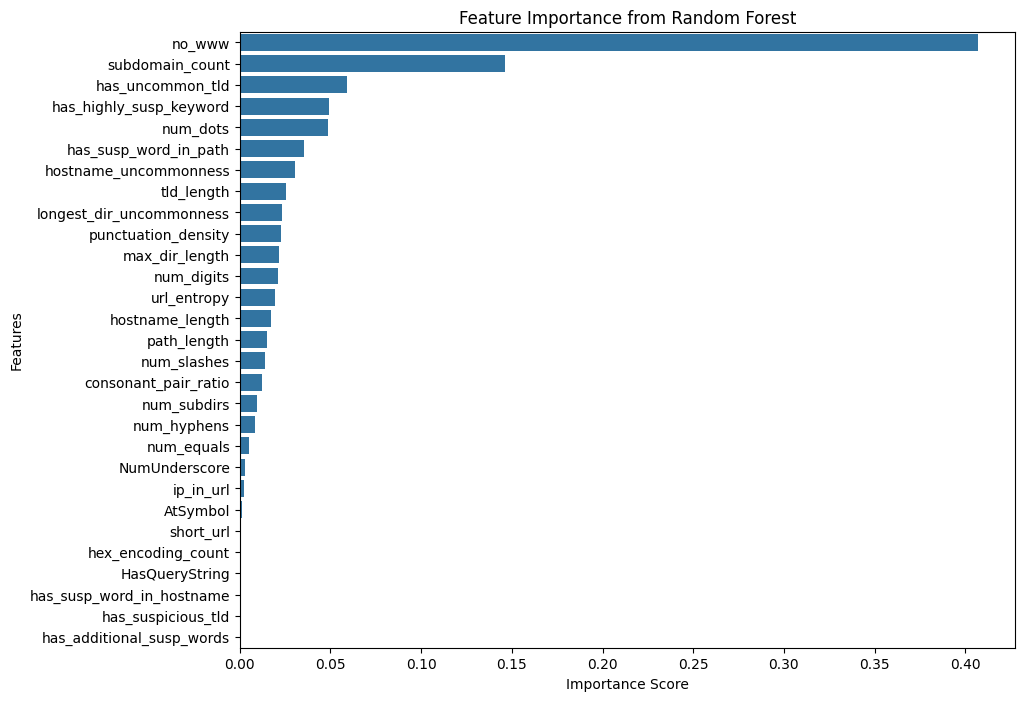

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
feature_names = X.columns  
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [ ]:
feature_names = [
    'num_dots', 'num_hyphens', 'num_slashes', 'num_digits', 'num_equals',
    'ip_in_url', 'has_highly_susp_keyword', 'hostname_length',
    'has_additional_susp_words', 'has_suspicious_tld', 'has_uncommon_tld',
    'url_entropy', 'subdomain_count', 'no_www', 'tld_length', 'short_url',
    'consonant_pair_ratio', 'punctuation_density', 'hex_encoding_count',
    'num_subdirs', 'AtSymbol', 'NumUnderscore', 'HasQueryString', 'path_length',
    'has_susp_word_in_path','has_susp_word_in_hostname', 'max_dir_length'
]
results_df = pd.DataFrame(X_test, columns=feature_names)

results_df['true_label'] = y_test
results_df['predicted_label'] = y_pred_rf

In [ ]:
if 'url' in df_RF.columns:
    results_df['url'] = df_RF.loc[results_df.index, 'url']

false_negatives_df = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)]

print(f"Found {len(false_negatives_df)} false negatives to analyze.")
print(false_negatives_df.head(30))

Found 960 false negatives to analyze.
        num_dots  num_hyphens  num_slashes  num_digits  num_equals  ip_in_url  \
428645         2            0            6           4           0          0   
445407         3            4            5          36           4          0   
430448         3            0            9           0           0          0   
426069         3            0            5           8           0          0   
429395         2            0            4           0           0          0   
430441         2            0            5           4           0          0   
424519         2            0            5           0           0          0   
443903         3            0            4           5           1          0   
449512         3            1            3           0           0          0   
430432         2            1            6           0           0          0   
430998         2            0            4           0           0     

In [ ]:

train_urls = df_RF.loc[X_train.index]['url']

benign_train_urls = train_urls[y_train == 0]

from collections import defaultdict

ngram_freqs = defaultdict(int)
total_ngrams = 0

print("Building N-gram frequency model from benign training data...")
for url in benign_train_urls:
    try:
        hostname = urlparse(url).hostname
        if hostname:
            domain_parts = hostname.split('.')
            if len(domain_parts) > 2 and domain_parts[0] == 'www':
                core_domain = domain_parts[1]
            elif len(domain_parts) > 1:
                core_domain = domain_parts[0]
            else:
                core_domain = hostname
            
            for i in range(len(core_domain) - 1):
                ngram = core_domain[i:i+2]
                ngram_freqs[ngram] += 1
                total_ngrams += 1
            for i in range(len(core_domain) - 2):
                ngram = core_domain[i:i+3]
                ngram_freqs[ngram] += 1
                total_ngrams += 1
    except:
        continue

for ngram in ngram_freqs:
    ngram_freqs[ngram] = ngram_freqs[ngram] / total_ngrams

print("N-gram model built successfully.")

Building N-gram frequency model from benign training data...
N-gram model built successfully.


In [ ]:
import numpy as np


def calculate_uncommonness_score(text, ngram_model, total_ngrams):
    if not isinstance(text, str) or not text:
        return 0
        
    score = 0
    num_ngrams_in_text = 0
    
    for i in range(len(text) - 1):
        ngram = text[i:i+2]
        prob = ngram_model.get(ngram, 1.0 / (total_ngrams + 1))
        score += -np.log(prob)
        num_ngrams_in_text += 1
        
    for i in range(len(text) - 2):
        ngram = text[i:i+3]
        prob = ngram_model.get(ngram, 1.0 / (total_ngrams + 1))
        score += -np.log(prob)
        num_ngrams_in_text += 1
        
    if num_ngrams_in_text == 0:
        return 0
    return score / num_ngrams_in_text

In [ ]:
from urllib.parse import urlparse
import pandas as pd


def robust_url_parser(url):
    default_return = ('', '', '', 0) 
    if not isinstance(url, str):
        return default_return
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname if parsed.hostname else ''
        path = parsed.path if parsed.path else ''
        
        directories = [d for d in path.split('/') if d]
        if not directories:
            longest_dir, max_len = '', 0
        else:
            longest_dir = max(directories, key=len)
            max_len = len(longest_dir)
            
        return hostname, path, longest_dir, max_len
    except ValueError:
        return default_return

In [ ]:
component_cols = ['hostname2', 'path', 'longest_dir', 'max_dir_len']

if not all(col in df_RF.columns for col in component_cols):
    print("Parsing URL components safely...")
    parsed_components = df_RF['url'].apply(robust_url_parser)
    components_df = pd.DataFrame(parsed_components.tolist(), index=df_RF.index, columns=component_cols)
    df_RF = df_RF.join(components_df)
    print("URL components added.")
else:
    print("URL component columns already exist. Skipping parsing.")

URL component columns already exist. Skipping parsing.


In [ ]:
ngram_feature_cols = ['hostname_uncommonness', 'longest_dir_uncommonness']

if not all(col in df_RF.columns for col in ngram_feature_cols):
    print("Creating N-gram features from safe columns...")
    df_RF['hostname_uncommonness'] = df_RF['hostname'].apply(
        lambda h: calculate_uncommonness_score(h, ngram_freqs, total_ngrams)
    )
    df_RF['longest_dir_uncommonness'] = df_RF['longest_dir'].apply(
        lambda d: calculate_uncommonness_score(d, ngram_freqs, total_ngrams)
    )
    print("N-gram features created.")
else:
    print("N-gram features already exist. Skipping creation.")

Creating N-gram features from safe columns...
N-gram features created.
